In [ ]:
# Environment setup
#!pip install scikit-learn opencv-python-headless matplotlib pandas

# Dataset
#!wget https://data.lhncbc.nlm.nih.gov/public/Pills/rximage.zip -O rximage.zip
#!unzip rximage.zip -d rximage

In [12]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("RxImage Drug Classification") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "120g") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.cores", "20") \
    .config("spark.driver.cores", "4") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "128MB") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "1g") \
    .config("spark.executor.memoryOffHeap.enabled", "true") \
    .config("spark.executor.memoryOffHeap.size", "32g") \
    .config("spark.network.timeout", "1200s") \
    .config("spark.executor.heartbeatInterval", "120s") \
    .config("spark.task.maxFailures", "3") \
    .config("spark.stage.maxConsecutiveAttempts", "8") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .config("spark.sql.parquet.enableVectorizedReader", "false") \
    .getOrCreate()



In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, coalesce

spark = SparkSession.builder.getOrCreate()

# loading CSV
csv_path = '/expanse/lustre/projects/uci150/arodriguez6/rximage/table.csv'
df = spark.read.option("header", True).csv(csv_path)

image_cols = [
    "RXBASE 120", "RXBASE 300", "RXBASE 600",
    "RXBASE 800", "RXBASE 1024", "RXBASE ORIGINAL"
]

# at least one image path exists
image_exists_condition = None
for c in image_cols:
    condition = col(c).isNotNull()
    image_exists_condition = condition if image_exists_condition is None else (image_exists_condition | condition)

df_valid = df.filter(col("name").isNotNull() & (col("name") != "NULL") & image_exists_condition)

print(f"Valid entries with at least one image and label: {df_valid.count()}")

Valid entries with at least one image and label: 4332


In [18]:
df.printSchema()
df.show(5)

root
 |-- ndc11: string (nullable = true)
 |-- rxcui: string (nullable = true)
 |-- name: string (nullable = true)
 |-- rxnavImageObjectId: string (nullable = true)
 |-- rxnavImageFileName: string (nullable = true)
 |-- nlmImageFileName: string (nullable = true)
 |-- RXNAV 120: string (nullable = true)
 |-- RXBASE 120: string (nullable = true)
 |-- RXNAV 300: string (nullable = true)
 |-- RXBASE 300: string (nullable = true)
 |-- RXNAV 600: string (nullable = true)
 |-- RXBASE 600: string (nullable = true)
 |-- RXNAV 800: string (nullable = true)
 |-- RXBASE 800: string (nullable = true)
 |-- RXNAV 1024: string (nullable = true)
 |-- RXBASE 1024: string (nullable = true)
 |-- RXNAV ORIGINAL: string (nullable = true)
 |-- RXBASE ORIGINAL: string (nullable = true)

+-------------+------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------

In [19]:
# Count how many image paths per resolution excluding null 
res_counts = df_valid.select([
    count(when(col(c).isNotNull(), c)).alias(c.replace("RXNAV ", "res_")) for c in image_cols
])
res_counts.show()

# Cpint how many image paths per resolution are null
missing_counts = df_valid.select([
    count(when(col(c).isNull(), c)).alias(f"missing_{c.replace(' ', '_')}") for c in image_cols
])
missing_counts.show()




+----------+----------+----------+----------+-----------+---------------+
|RXBASE 120|RXBASE 300|RXBASE 600|RXBASE 800|RXBASE 1024|RXBASE ORIGINAL|
+----------+----------+----------+----------+-----------+---------------+
|      4332|      4332|      4332|      4332|       4332|           4332|
+----------+----------+----------+----------+-----------+---------------+

+------------------+------------------+------------------+------------------+-------------------+-----------------------+
|missing_RXBASE_120|missing_RXBASE_300|missing_RXBASE_600|missing_RXBASE_800|missing_RXBASE_1024|missing_RXBASE_ORIGINAL|
+------------------+------------------+------------------+------------------+-------------------+-----------------------+
|                 0|                 0|                 0|                 0|                  0|                      0|
+------------------+------------------+------------------+------------------+-------------------+-----------------------+



In [20]:
label_counts = df_valid.groupBy("name").agg(count("*").alias("image_count")).orderBy(col("image_count").desc())
label_counts.show(15, truncate=False)

print(f"Total unique pill classes: {df_valid.select('name').distinct().count()}")

+------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|name                                                                                                                                                  |image_count|
+------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|pantoprazole 40 MG Delayed Release Oral Tablet                                                                                                        |10         |
|Lisinopril 5 MG Oral Tablet                                                                                                                           |9          |
|Simvastatin 5 MG Oral Tablet                                                                                                                          |9          |
|Lisinopri

/scratch/arodriguez6/job_40156559/ipykernel_1412579/166847964.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


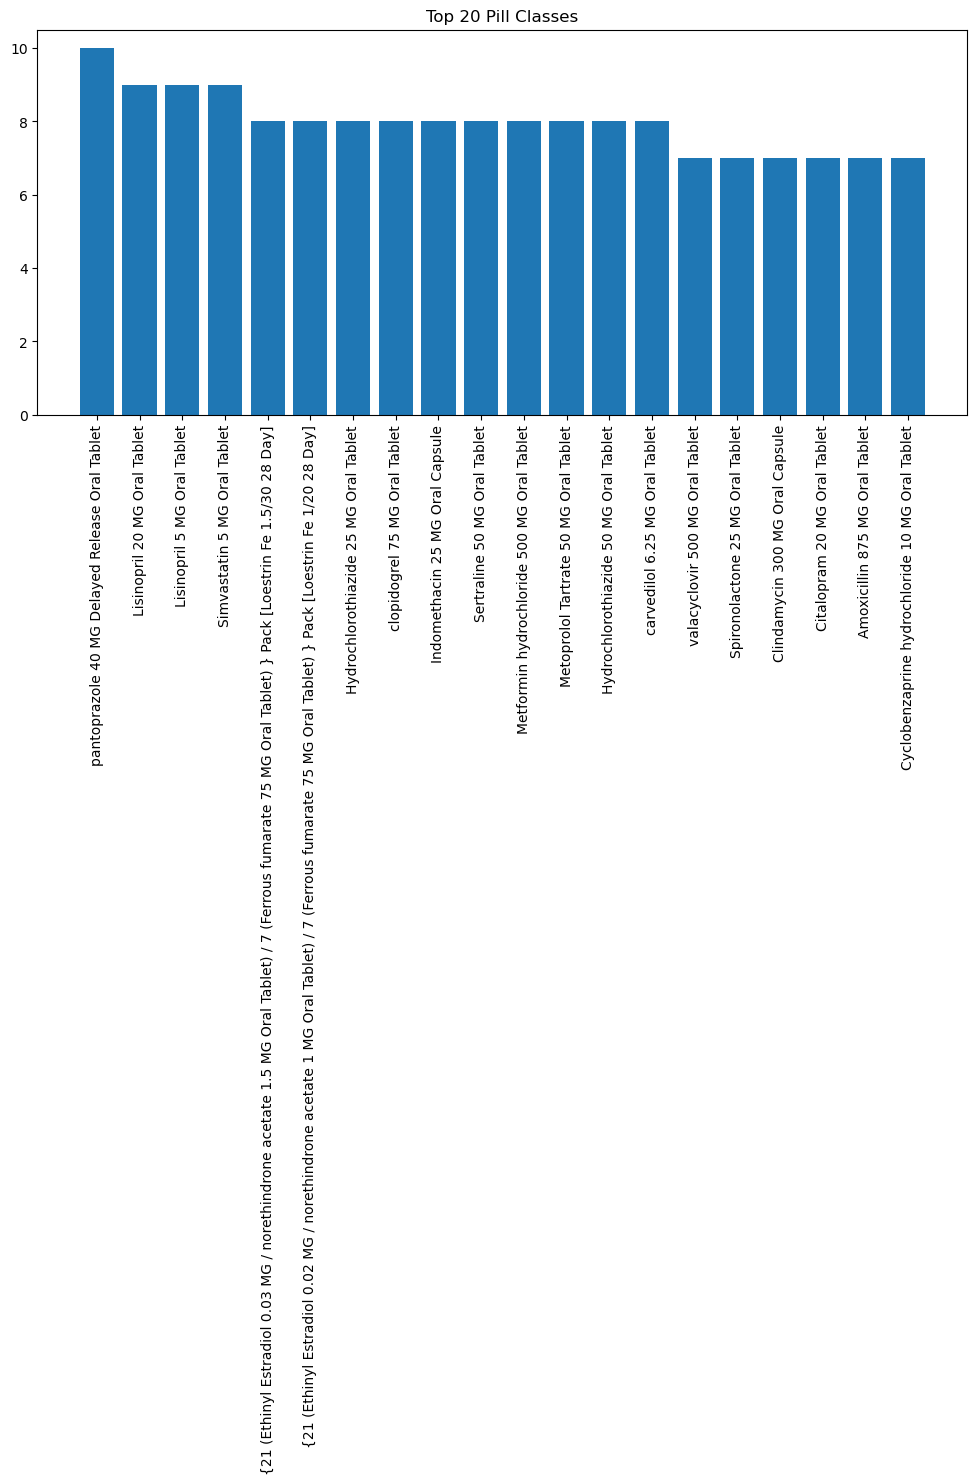

In [21]:
class_counts_pd = df_valid.groupBy('name').count().toPandas().sort_values('count', ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(class_counts_pd['name'][:20], class_counts_pd['count'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Pill Classes')
plt.tight_layout()
plt.show()


In [22]:
from pyspark.sql.functions import coalesce, col

df_valid = df_valid.withColumn(
    "image_path",
    coalesce(
        col("RXBASE ORIGINAL"), col("RXBASE 1024"),
        col("RXBASE 800"), col("RXBASE 600"),
        col("RXBASE 300"), col("RXBASE 120")
    )
)


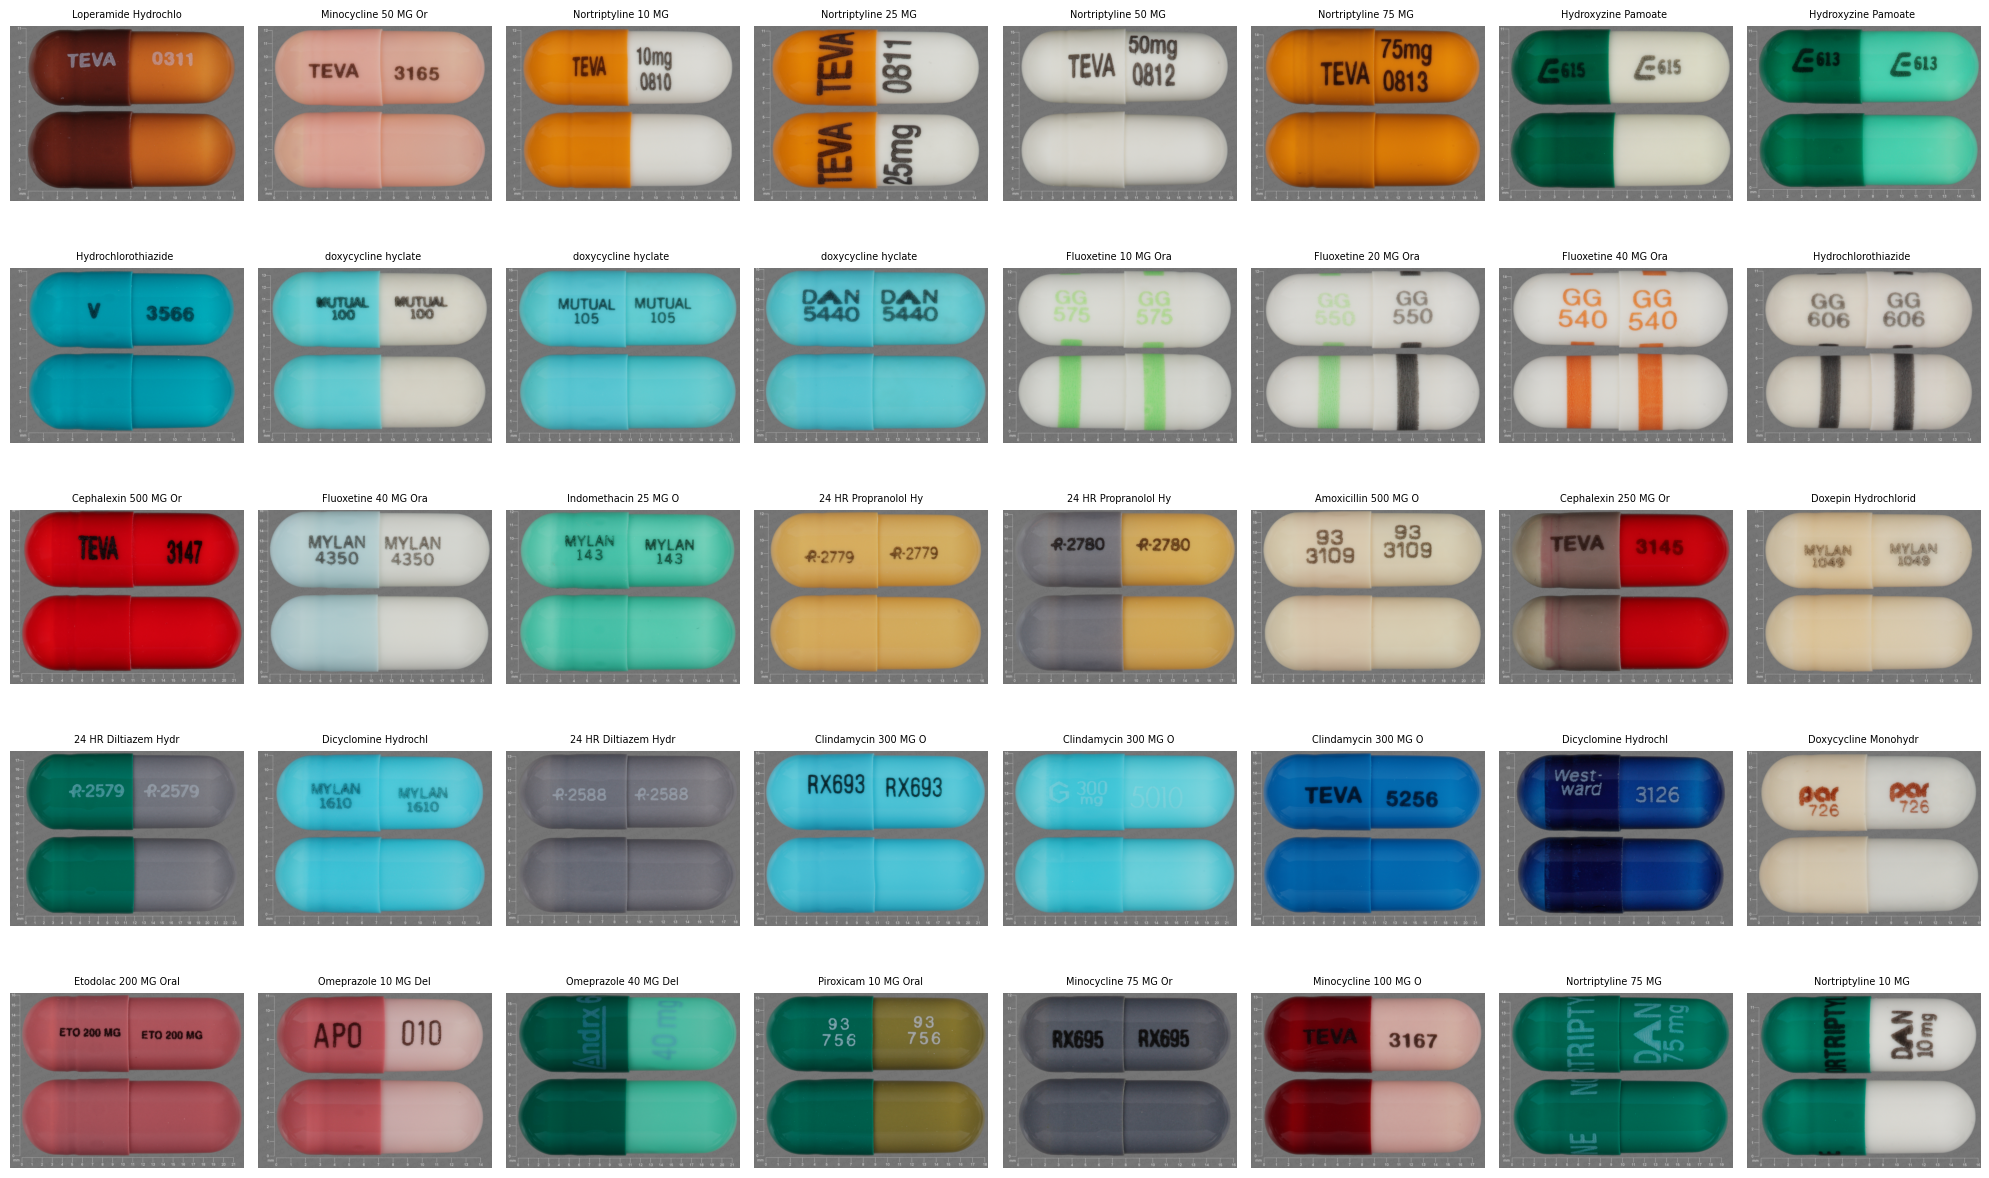

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import math

# Get sample data
sample_pd = df_valid.select("name", "image_path").limit(40).toPandas()
res_path = '/expanse/lustre/projects/uci150/arodriguez6/rximage/'

num_samples = len(sample_pd)
cols = 8
rows = math.ceil(num_samples / cols)

plt.figure(figsize=(20, 2.5 * rows))
for i, row in sample_pd.iterrows():
    try:
        img = Image.open(os.path.join(res_path, row["image_path"]))
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(row["name"][:20], fontsize=7)
        plt.axis("off")
    except:
        continue

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os


csv_path = "/expanse/lustre/projects/uci150/arodriguez6/rximage/table.csv"
df = pd.read_csv(csv_path)

processed_rows = []


# use 600 res because original taking very long. Original to 600 is not much of a loss in detail since we are downscaling anyways
# so many memory issues despite 200gb. Trying 300 res
for idx, row in enumerate(df.iterrows(), 1):
    row = row[1]
    img_path = f"/expanse/lustre/projects/uci150/arodriguez6/rximage/{row['RXBASE 300']}"
    if not os.path.exists(img_path):
        continue 
    img = cv2.imread(img_path)
    if img is None:
        continue 
    img = cv2.resize(img, (224, 224)) 
    img = img / 255.0  
    flat = img.flatten() 
    processed_row = {
        'name': row['name'],
        **{f'feat_{i}': flat[i] for i in range(len(flat))} 
    }
    processed_rows.append(processed_row)

    if idx % 100 == 0:
        print(f"Processed {idx} rows")

print(f"Finished. Total processed rows: {len(processed_rows)}")

out_df = pd.DataFrame(processed_rows)
out_df.to_parquet("/expanse/lustre/projects/uci150/arodriguez6/rximage/processed.parquet")  # save for Spark

Processed 100 rows
Processed 200 rows
Processed 300 rows
Processed 400 rows
Processed 500 rows
Processed 600 rows
Processed 700 rows
Processed 800 rows
Processed 900 rows
Processed 1000 rows
Processed 1100 rows
Processed 1200 rows
Processed 1300 rows
Processed 1400 rows
Processed 1500 rows
Processed 1600 rows
Processed 1700 rows
Processed 1800 rows
Processed 1900 rows
Processed 2000 rows
Processed 2100 rows
Processed 2200 rows
Processed 2300 rows
Processed 2400 rows
Processed 2500 rows
Processed 2600 rows
Processed 2700 rows
Processed 2800 rows


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# load parquet
spark_df = spark.read.parquet("/expanse/lustre/projects/uci150/arodriguez6/rximage/processed.parquet")

# encode drug name as label
indexer = StringIndexer(inputCol="name", outputCol="label")
spark_df = indexer.fit(spark_df).transform(spark_df)

# build vector out of feature columns
feature_cols = [col for col in spark_df.columns if col.startswith('feat_')]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
spark_df = assembler.transform(spark_df)


rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20)


train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)
model = rf.fit(train_data)
predictions = model.transform(test_data)

# eval
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")


predictions.select("name", "label", "prediction").show(10)


In [5]:
### Preprocessing Step

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, lit, when, concat_ws, regexp_replace
from pyspark.sql.types import ArrayType, FloatType
import numpy as np
from PIL import Image
import os
import pandas as pd


def process_single_image(image_path, target_size=(224, 224)):
    try:
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
            img_array = np.array(img_resized, dtype=np.float32) / 255.0
            features = img_array.flatten().tolist()
            return features
            
    except Exception as e:
        print(f"couldnt process {image_path}: {str(e)}")
        feature_dim = target_size[0] * target_size[1] * 3
        return [0.0] * feature_dim

print("loading csv")
df_pandas = pd.read_csv("/expanse/lustre/projects/uci150/arodriguez6/rximage/table.csv")
print(f"got {len(df_pandas)} records")

image_columns = [col for col in df_pandas.columns if '300' in str(col)]

process_image_udf = udf(
    lambda path: process_single_image(path, (224, 224)), 
    ArrayType(FloatType())
)

df = spark.createDataFrame(df_pandas)

image_column = "RXBASE 300"
df = df.filter(col(image_column).isNotNull())

print("making image paths")
df = df.withColumn(
    "image_path",
    concat_ws(
        "/", 
        lit("/expanse/lustre/projects/uci150/arodriguez6/rximage"),
        regexp_replace(col(image_column), r"^[/\\]+", "")
    )
)

print("checking if images exist")
sample_paths = df.select("image_path").limit(5).collect()
valid_count = sum(1 for row in sample_paths if os.path.exists(row.image_path))
print(f"found {valid_count} valid images in sample")

df = df.repartition(16)

print("processing images")
df_processed = df.withColumn(
    "features", 
    process_image_udf(col("image_path"))
).select("name", "features", "image_path")

df_processed = df_processed.filter(col("features").isNotNull())
df_processed.cache()

try:
    processed_count = df_processed.count()
    print(f"processed {processed_count} images")
except Exception as e:
    print(f"counting failed: {e}")

print("saving data")
df_processed.write.mode("overwrite").parquet("/expanse/lustre/projects/uci150/arodriguez6/rximage/processed_pill_features.parquet")
print("saved to parquet file")

print("done with preprocessing")
spark.stop()

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count, desc
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, FloatType
import time

spark = SparkSession.builder \
    .appName("RxImage Drug Classification") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "120g") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.cores", "20") \
    .config("spark.driver.cores", "4") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "128MB") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "1g") \
    .config("spark.executor.memoryOffHeap.enabled", "true") \
    .config("spark.executor.memoryOffHeap.size", "32g") \
    .config("spark.network.timeout", "1200s") \
    .config("spark.executor.heartbeatInterval", "120s") \
    .config("spark.task.maxFailures", "3") \
    .config("spark.stage.maxConsecutiveAttempts", "8") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .config("spark.sql.parquet.enableVectorizedReader", "false") \
    .getOrCreate()

spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoint")

print("loading data")
df = spark.read.parquet("/expanse/lustre/projects/uci150/arodriguez6/rximage/processed_pill_features.parquet")

total_samples = df.count()
unique_drugs = df.select("name").distinct().count()
print(f"got {total_samples} samples and {unique_drugs} different drugs")


##FOR TEST
#print("sampling data")
#df = df.sample(0.5, seed=42)
#print("sampled 50% of data")

df = df.filter(col("name").isNotNull())

print("getting top 20 drug classes")
class_counts = df.groupBy("name").agg(count("*").alias("count")).orderBy(desc("count")).limit(20)
top_classes = [row.name for row in class_counts.collect()]
print(f"got {len(top_classes)} top classes")

df = df.filter(col("name").isin(top_classes))
df = df.repartition(8, col("name"))

print("features to vectors")
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr) if arr is not None else None, VectorUDT())
df = df.withColumn("assembled_features", array_to_vector_udf(col("features")))

indexer = StringIndexer(inputCol="name", outputCol="label", handleInvalid="skip")
indexer_model = indexer.fit(df)
df_indexed = indexer_model.transform(df)

df_final = df_indexed.select("label", "assembled_features", "name")

train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

train_df = train_df.cache()
test_df = test_df.cache()

train_count = train_df.count()
test_count = test_df.count()
print(f"training set: {train_count}, test set: {test_count}")
print(f"number of classes: {len(indexer_model.labels)}")

print("training random forest")
start_time = time.time()
rf = RandomForestClassifier(
    featuresCol="assembled_features",
    labelCol="label",
    numTrees=30,
    maxDepth=15,
    maxBins=32,
    subsamplingRate=0.8,
    seed=42
)
rf_model = rf.fit(train_df)
rf_train_time = time.time() - start_time
print(f"random forest done in {rf_train_time:.2f} seconds")

print("testing random forest")
start_time = time.time()
rf_predictions = rf_model.transform(test_df)

rf_accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
rf_accuracy = rf_accuracy_evaluator.evaluate(rf_predictions)

rf_f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)
rf_f1_score = rf_f1_evaluator.evaluate(rf_predictions)

rf_weighted_precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
)
rf_weighted_precision = rf_weighted_precision_evaluator.evaluate(rf_predictions)

rf_weighted_recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
)
rf_weighted_recall = rf_weighted_recall_evaluator.evaluate(rf_predictions)

print("Random Forest Results:")
print(f"accuracy: {rf_accuracy:.4f}")
print(f"f1 score: {rf_f1_score:.4f}")
print(f"weighted precision: {rf_weighted_precision:.4f}")
print(f"weighted recall: {rf_weighted_recall:.4f}")

rf_converter = IndexToString(inputCol="prediction", outputCol="predicted_drug", labels=indexer_model.labels)
rf_predictions_with_names = rf_converter.transform(rf_predictions)

print("some random forest predictions:")
rf_predictions_with_names.select("name", "predicted_drug", "prediction", "label").show(10, truncate=False)

rf_eval_time = time.time() - start_time
print(f"random forest eval in {rf_eval_time:.2f} seconds")

rf_model_path = "/expanse/lustre/projects/uci150/arodriguez6/rximage/models/random_forest"
rf_model.write().overwrite().save(rf_model_path)
print(f"saved random forest to {rf_model_path}")

print("starting logistic regression")
try:
    start_time = time.time()
    lr = LogisticRegression(
        featuresCol="assembled_features",
        labelCol="label",
        maxIter=5,
        regParam=0.1,
        elasticNetParam=0.1,
        standardization=True,
        threshold=0.5,
        aggregationDepth=3
    )
    lr_model = lr.fit(train_df)
    lr_train_time = time.time() - start_time
    print(f"logistic regression done in {lr_train_time:.2f} seconds")
    
    print("testing logistic regression")
    start_time = time.time()
    lr_predictions = lr_model.transform(test_df)
    
    lr_accuracy_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy"
    )
    lr_accuracy = lr_accuracy_evaluator.evaluate(lr_predictions)
    
    lr_f1_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1"
    )
    lr_f1_score = lr_f1_evaluator.evaluate(lr_predictions)
    
    lr_weighted_precision_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
    )
    lr_weighted_precision = lr_weighted_precision_evaluator.evaluate(lr_predictions)
    
    lr_weighted_recall_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedRecall"
    )
    lr_weighted_recall = lr_weighted_recall_evaluator.evaluate(lr_predictions)
    
    print("Logistic Regression Results:")
    print(f"accuracy: {lr_accuracy:.4f}")
    print(f"f1 score: {lr_f1_score:.4f}")
    print(f"weighted precision: {lr_weighted_precision:.4f}")
    print(f"weighted recall: {lr_weighted_recall:.4f}")
    
    lr_converter = IndexToString(inputCol="prediction", outputCol="predicted_drug", labels=indexer_model.labels)
    lr_predictions_with_names = lr_converter.transform(lr_predictions)
    
    print("some logistic regression predictions:")
    lr_predictions_with_names.select("name", "predicted_drug", "prediction", "label").show(10, truncate=False)
    
    lr_eval_time = time.time() - start_time
    print(f"logistic regression eval done in {lr_eval_time:.2f} seconds")
    
    lr_model_path = "/expanse/lustre/projects/uci150/arodriguez6/rximage/models/logistic_regression"
    lr_model.write().overwrite().save(lr_model_path)
    print(f"saved logistic regression to {lr_model_path}")
    
except Exception as e:
    print(f"logistic regression failed: {e}")

indexer_path = "/expanse/lustre/projects/uci150/arodriguez6/rximage/models/indexer"
indexer_model.write().overwrite().save(indexer_path)
print(f"saved indexer to {indexer_path}")

print("done")
spark.stop()

loading data
got 4392 samples and 2112 different drugs
getting top 20 drug classes
got 20 top classes
features to vectors
training set: 127, test set: 32
number of classes: 20
training random forest
random forest done in 17.93 seconds
testing random forest
Random Forest Results:
accuracy: 0.3125
f1 score: 0.2979
weighted precision: 0.3255
weighted recall: 0.3125
some random forest predictions:
+----------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----+
|name                                          |predicted_drug                                                                                                                                        |prediction|label|
+----------------------------------------------+-------------------------------------------------------------------------------------------------------------------------

In [2]:
### Only using the reference images is no good. There is not enough data.
### Going to try and use the 130,000 customer images

test


In [9]:
!wget https://data.lhncbc.nlm.nih.gov/public/Pills/directory_consumer_grade_images.txt -O directory_consumer_grade_images.txt


IOStream.flush timed out
--2025-06-08 14:01:19--  https://data.lhncbc.nlm.nih.gov/public/Pills/directory_consumer_grade_images.txt
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.167.192.32, 3.167.192.60, 3.167.192.56, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.167.192.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15903982 (15M) [text/plain]
Saving to: ‘directory_consumer_grade_images.txt’

directory_consumer_ 100%[===================>]  15.17M  22.4MB/s    in 0.7s    

2025-06-08 14:01:20 (22.4 MB/s) - ‘directory_consumer_grade_images.txt’ saved [15903982/15903982]



In [ ]:
### DOWNLOADING 130k CONSUMER IMAGES

import os
import urllib.request
from collections import defaultdict

# paths and url base
txt_file = "directory_consumer_grade_images.txt"
base_url = "https://data.lhncbc.nlm.nih.gov/public/Pills/"
output_dir = "c3pi_images"
os.makedirs(output_dir, exist_ok=True)

drug_counts = defaultdict(int)

downloaded = 0
skipped = 0
failed = 0

with open(txt_file, "r") as f:
    for line in f:
        parts = line.strip().split("|")
        if len(parts) != 5:
            continue

        img_path = parts[2]
        drug = parts[4]

        folder_name = drug.replace(" ", "_").replace("/", "_")[:60]
        full_folder_path = os.path.join(output_dir, folder_name)
        os.makedirs(full_folder_path, exist_ok=True)

        url = base_url + img_path
        filename = os.path.basename(img_path)
        save_path = os.path.join(full_folder_path, filename)

        if os.path.exists(save_path):
            skipped += 1
            continue

        try:
            urllib.request.urlretrieve(url, save_path)
            downloaded += 1
            drug_counts[drug] += 1
        except:
            print("error downloading:", url)
            failed += 1

print("done")
print("downloaded:", downloaded)
print("skipped:", skipped)
print("failed:", failed)


INFO:py4j.clientserver:Error while sending or receiving.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 503, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer
INFO:py4j.clientserver:Closing down clientserver connection
INFO:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 503, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python

In [ ]:
print("Test")

In [2]:
## stopping download after 2 hours.

import os

root = "c3pi_images"

drug_folders = [f for f in os.listdir(root) if os.path.isdir(os.path.join(root, f))]
print("Number of drug folders:", len(drug_folders))

total_images = sum(
    len(files)
    for _, _, files in os.walk(root)
)
print("Total images:", total_images)

Number of drug folders: 338
Total images: 12276


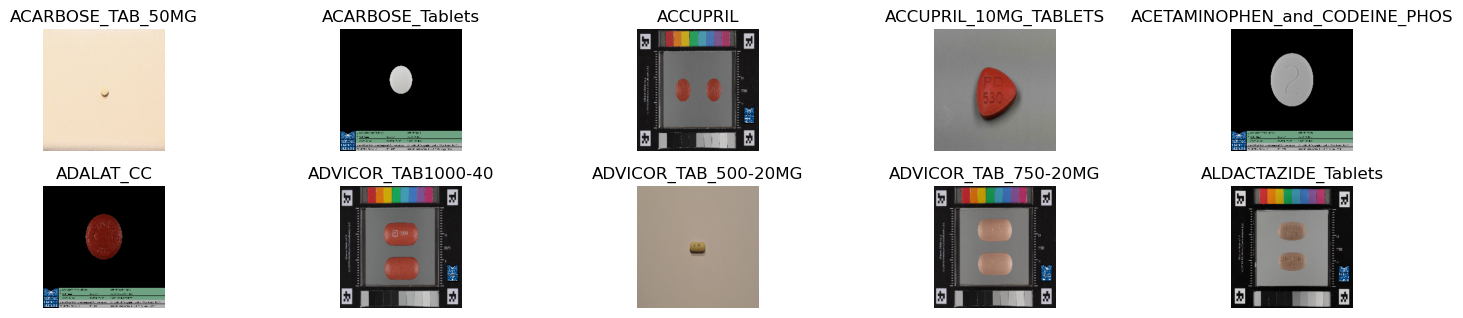

In [6]:
import matplotlib.pyplot as plt
import cv2
import random

root = "c3pi_images"
drug_folders = sorted(os.listdir(root))[:10] 

plt.figure(figsize=(15, 8))

i = 1
for drug in drug_folders:
    folder_path = os.path.join(root, drug)
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not images:
        continue
    img_path = os.path.join(folder_path, random.choice(images))
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    plt.subplot(5, 5, i)
    plt.imshow(img)
    plt.title(drug[:30])
    plt.axis("off")
    i += 1
    if i > 10:
        break

plt.tight_layout()
plt.show()

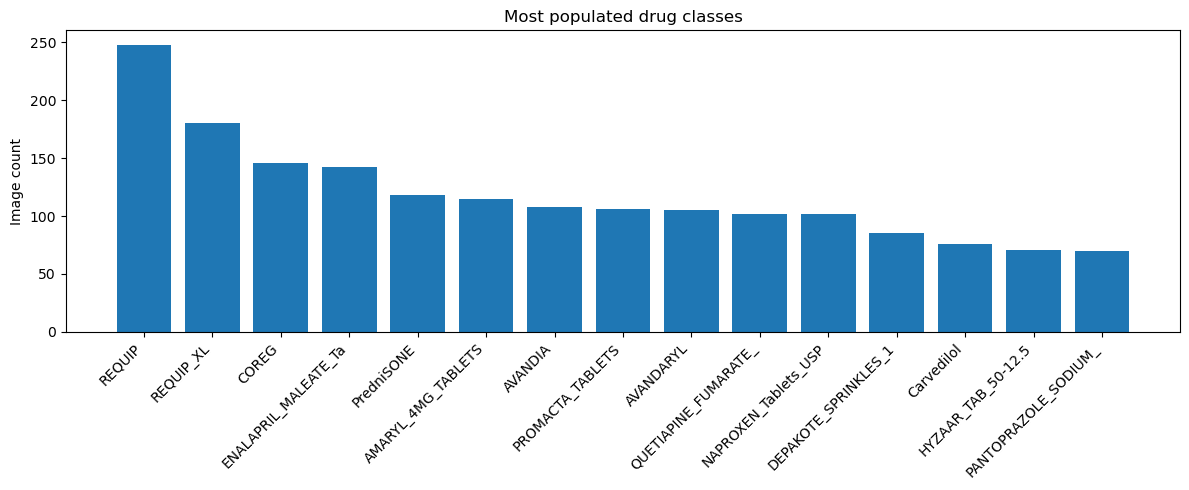

In [8]:
from collections import Counter

counts = Counter()

for folder in os.listdir(root):
    folder_path = os.path.join(root, folder)
    if not os.path.isdir(folder_path):
        continue
    n_files = len([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.cr2'))
    ])
    counts[folder] = n_files


top = counts.most_common(15)

plt.figure(figsize=(12, 5))
plt.bar([x[0][:20] for x in top], [x[1] for x in top])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Image count")
plt.title("Most populated drug classes")
plt.tight_layout()
plt.show()


In [ ]:
## Going to attempt to train model on this data with somewhat similar code I used previously.

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, lit
from pyspark.sql.types import ArrayType, FloatType, StringType, StructType, StructField
import numpy as np
from PIL import Image
import os

def process_single_image(image_path, target_size=(224, 224)):
    try:
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
            img_array = np.array(img_resized, dtype=np.float32) / 255.0
            features = img_array.flatten().tolist()
            return features
            
    except Exception as e:
        print(f"couldnt process {image_path}: {str(e)}")
        feature_dim = target_size[0] * target_size[1] * 3
        return [0.0] * feature_dim

print("scanning image folders")

image_rows = []
root_dir = "c3pi_images"

for drug_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, drug_name)
    if not os.path.isdir(folder_path):
        continue

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.cr2')):
            image_rows.append({
                "name": drug_name,
                "image_path": os.path.join(folder_path, filename)
            })

print(f"collected {len(image_rows)} image paths")

spark = SparkSession.builder.getOrCreate()

schema = StructType([
    StructField("name", StringType(), True),
    StructField("image_path", StringType(), True)
])

df = spark.createDataFrame(image_rows, schema)

process_image_udf = udf(
    lambda path: process_single_image(path, (224, 224)), 
    ArrayType(FloatType())
)

df = df.repartition(16)

print("processing images")
df_processed = df.withColumn(
    "features", 
    process_image_udf(col("image_path"))
).select("name", "features", "image_path")

df_processed = df_processed.filter(col("features").isNotNull())
df_processed.cache()

try:
    processed_count = df_processed.count()
    print(f"processed {processed_count} images")
except Exception as e:
    print(f"counting failed: {e}")

print("saving data")
df_processed.write.mode("overwrite").parquet("/expanse/lustre/projects/uci150/arodriguez6/rximage/processed_pill_features.parquet")
print("saved to parquet file")

print("done with preprocessing")



scanning image folders
collected 11970 image paths
processing images
processed 11970 images
saving data
saved to parquet file
done with preprocessing


In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count, desc
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, FloatType
import time

print("loading data")
df = spark.read.parquet("/expanse/lustre/projects/uci150/arodriguez6/rximage/processed_pill_features.parquet")

total_samples = df.count()
unique_drugs = df.select("name").distinct().count()
print(f"{total_samples} samples and {unique_drugs} different drugs")

df = df.filter(col("name").isNotNull())

print("getting top 20 drug classes")
class_counts = df.groupBy("name").agg(count("*").alias("count")).orderBy(desc("count")).limit(20)
top_classes = [row.name for row in class_counts.collect()]
print(f"got {len(top_classes)} top classes")

df = df.filter(col("name").isin(top_classes))
df = df.repartition(8, col("name"))

print("features to vectors")
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr) if arr is not None else None, VectorUDT())
df = df.withColumn("assembled_features", array_to_vector_udf(col("features")))

indexer = StringIndexer(inputCol="name", outputCol="label", handleInvalid="skip")
indexer_model = indexer.fit(df)
df_indexed = indexer_model.transform(df)

df_final = df_indexed.select("label", "assembled_features", "name")

train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

train_df = train_df.cache()
test_df = test_df.cache()

train_count = train_df.count()
test_count = test_df.count()
print(f"training set: {train_count}, test set: {test_count}")
print(f"number of classes: {len(indexer_model.labels)}")

print("starting logistic regression")
try:
    start_time = time.time()
    lr = LogisticRegression(
        featuresCol="assembled_features",
        labelCol="label",
        maxIter=5,
        regParam=0.1,
        elasticNetParam=0.1,
        standardization=True,
        threshold=0.5,
        aggregationDepth=3
    )
    lr_model = lr.fit(train_df)
    lr_train_time = time.time() - start_time
    print(f"logistic regression done in {lr_train_time:.2f} seconds")
    
    print("testing logistic regression")
    start_time = time.time()
    lr_predictions = lr_model.transform(test_df)
    
    lr_accuracy_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy"
    )
    lr_accuracy = lr_accuracy_evaluator.evaluate(lr_predictions)
    
    lr_f1_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1"
    )
    lr_f1_score = lr_f1_evaluator.evaluate(lr_predictions)
    
    lr_weighted_precision_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
    )
    lr_weighted_precision = lr_weighted_precision_evaluator.evaluate(lr_predictions)
    
    lr_weighted_recall_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedRecall"
    )
    lr_weighted_recall = lr_weighted_recall_evaluator.evaluate(lr_predictions)
    
    print("Logistic Regression Results:")
    print(f"accuracy: {lr_accuracy:.4f}")
    print(f"f1 score: {lr_f1_score:.4f}")
    print(f"weighted precision: {lr_weighted_precision:.4f}")
    print(f"weighted recall: {lr_weighted_recall:.4f}")
    
    lr_converter = IndexToString(inputCol="prediction", outputCol="predicted_drug", labels=indexer_model.labels)
    lr_predictions_with_names = lr_converter.transform(lr_predictions)
    
    print("logistic regression predictions:")
    lr_predictions_with_names.select("name", "predicted_drug", "prediction", "label").show(10, truncate=False)
    
    lr_eval_time = time.time() - start_time
    print(f"logistic regression eval done in {lr_eval_time:.2f} seconds")
    
    lr_model_path = "/expanse/lustre/projects/uci150/arodriguez6/rximage/models/logistic_regression"
    lr_model.write().overwrite().save(lr_model_path)
    print(f"saved logistic regression to {lr_model_path}")
    
except Exception as e:
    print(f"logistic regression failed: {e}")

indexer_path = "/expanse/lustre/projects/uci150/arodriguez6/rximage/models/indexer"
indexer_model.write().overwrite().save(indexer_path)
print(f"saved indexer to {indexer_path}")

print("done")


loading data
11970 samples and 338 different drugs
getting top 20 drug classes
got 20 top classes
features to vectors
training set: 1737, test set: 381
number of classes: 20
starting logistic regression
logistic regression done in 145.25 seconds
testing logistic regression
Logistic Regression Results:
accuracy: 0.2625
f1 score: 0.1933
weighted precision: 0.2003
weighted recall: 0.2625
logistic regression predictions:
+-----------------------------+---------------------------+----------+-----+
|name                         |predicted_drug             |prediction|label|
+-----------------------------+---------------------------+----------+-----+
|ENALAPRIL_MALEATE_Tablets_USP|REQUIP                     |0.0       |3.0  |
|ENALAPRIL_MALEATE_Tablets_USP|REQUIP                     |0.0       |3.0  |
|ENALAPRIL_MALEATE_Tablets_USP|QUETIAPINE_FUMARATE_Tablets|10.0      |3.0  |
|ENALAPRIL_MALEATE_Tablets_USP|REQUIP_XL                  |1.0       |3.0  |
|ENALAPRIL_MALEATE_Tablets_USP|QUETIAPIN

Epoch 1 loss: 5.5170
Test Accuracy: 0.0264
Weighted F1 Score: 0.0057

Class Breakdown:

                                                  precision    recall  f1-score   support

                               ACARBOSE_TAB_50MG       0.00      0.00      0.00         8
                                ACARBOSE_Tablets       0.00      0.00      0.00         1
                                        ACCUPRIL       0.00      0.00      0.00         6
                           ACCUPRIL_10MG_TABLETS       0.00      0.00      0.00         4
ACETAMINOPHEN_and_CODEINE_PHOSPHATE_Tablets,_USP       0.00      0.00      0.00         9
                                       ADALAT_CC       0.00      0.00      0.00         5
                              ADVICOR_TAB1000-40       0.00      0.00      0.00         6
                            ADVICOR_TAB_500-20MG       0.00      0.00      0.00         4
                            ADVICOR_TAB_750-20MG       0.00      0.00      0.00         7
           

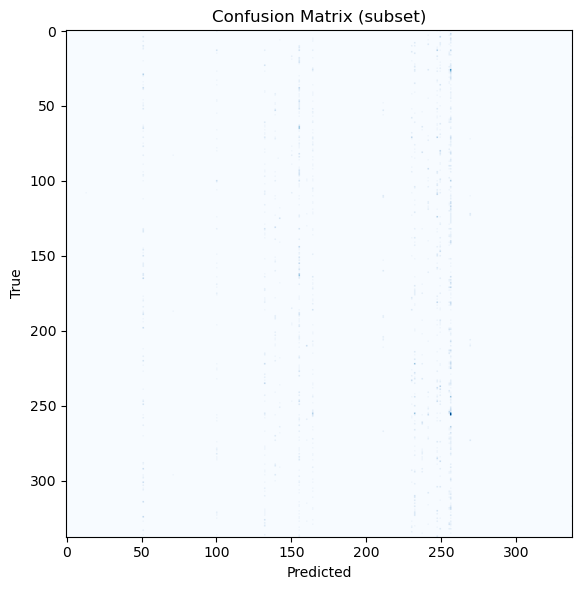

In [29]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import classification_report, accuracy_score, f1_score
from PIL import ImageFile
import matplotlib.pyplot as plt
import numpy as np

ImageFile.LOAD_TRUNCATED_IMAGES = True

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

full_dataset = ImageFolder("c3pi_images", transform=transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(full_dataset.classes))

device = torch.device("cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(1):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} loss: {loss.item():.4f}")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {acc:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

label_to_class = {i: cls for i, cls in enumerate(full_dataset.classes)}
target_names = [label_to_class[i] for i in sorted(set(all_labels)) if i in label_to_class]

print("\nClass Breakdown:\n")
print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

conf_matrix = torch.zeros(len(full_dataset.classes), len(full_dataset.classes))
for t, p in zip(all_labels, all_preds):
    conf_matrix[t, p] += 1

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix.numpy(), cmap="Blues")
plt.title("Confusion Matrix (subset)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
